## House Price Prediction?
After trying out the ideas in this Notebook I already know that a linear regression model will not lead to a top score in the competion. The reason I wanted to try it out is that it's a model that is reasonably simple to understand and get an intuitive feel for. I can more or less code the algorithm myself and this brings the benefit that it's a lot easier to understand what is going on and make the right choices when trying to improve the model by cleaning the data, trying out different parameters, et c.

Just applying Random Forest or Gradient Boosting without knowing how they work or what each parameter of the model does feels kind of scary. It might be reasonably easy to get a good "score" but how can I tell if I reached the right conclusions, how well the model would transfer to a sligthly different scenario or how changes in the raw data would affect the model? I would love to learn more about these models as well but as I've recently gotten started with this I am taking one step at a time.

I've tried to include all relevant steps of my analysis but have omitted some that would result in a long output. Ok, let's get started with some imports and loading the data.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import seaborn as sns


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer

from scipy.stats import skew

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
# Any results you write to the current directory are saved as output.

/opt/conda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load data.
train = pd.read_csv('train.csv', index_col='id', parse_dates=[1], 
                    true_values=['yes'], false_values=['no'])
test = pd.read_csv('test.csv', index_col='id', parse_dates=[1], 
                   true_values=['yes'], false_values=['no'])
print(train.shape)
print(test.shape)

(30471, 291)
(7662, 290)


## Exploratory Data Analysis

The first thing that is usually doen are as fillows:
1. Explore distrubution of Target Varibale
2. Explore correlation between Target variable and other features
3. Combine Test and Train dataset,
    3.1 Explore the missing values
    3.2 Explore outliers
    3.3 Impute missing values or drop columns with lot of missing data 
        3.3.1 For numerical datasets, impute missing values with median
        3.3.2 For categorical dataset impute missing values with the most frequent values
    3.4 Remove outliers
4. If necessary transform features with skewed distributions into respective log format
5. Normalize all columns into standard Z distribution (mean=0, sd=[-1,1])

In [3]:
train.describe(include=[np.object])

,product_type,sub_area,ecology
count,30471,30471,30471
unique,2,146,5
top,Investment,Poselenie Sosenskoe,poor
freq,19448,1776,8018


It seems that we have only 3 categorical features

In [4]:
train_numeric = train.select_dtypes(exclude=[np.object])
for m in range(train_numeric.columns.size/5):
    d = train_numeric[train_numeric.columns[m*5: (m+1)*5]]
    print d.describe()
    print "-------------------------------------------"

            full_sq       life_sq         floor     max_floor
count  30471.000000  24088.000000  30304.000000  20899.000000
mean      54.214269     34.403271      7.670803     12.558974
std       38.031487     52.285733      5.319989      6.756550
min        0.000000      0.000000      0.000000      0.000000
25%       38.000000     20.000000      3.000000      9.000000
50%       49.000000     30.000000      6.500000     12.000000
75%       63.000000     43.000000     11.000000     17.000000
max     5326.000000   7478.000000     77.000000    117.000000
-------------------------------------------
           material    build_year      num_room      kitch_sq         state
count  20899.000000  1.686600e+04  20899.000000  20899.000000  16912.000000
mean       1.827121  3.068057e+03      1.909804      6.399301      2.107025
std        1.481154  1.543878e+05      0.851805     28.265979      0.880148
min        1.000000  0.000000e+00      0.000000      0.000000      1.000000
25%        1.00000

And how is sale distribution?

/opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


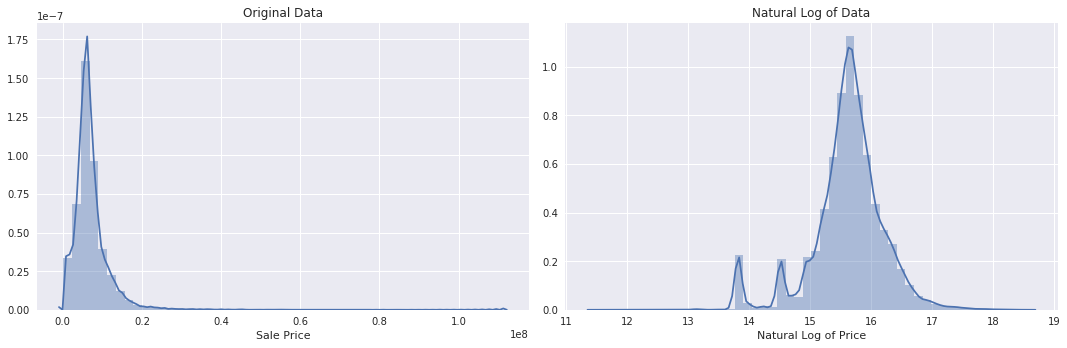

In [5]:
target = train['price_doc'] #Skip the SalePrice
target_log = np.log(target)
target_log = target_log.apply (lambda x : 0 if x == - np.inf else x)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(target, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(target_log, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Price')
plt.tight_layout()

The above shows that target feature need to be transformed into log base and normalized

#### Correlation?

In [6]:
corr=train.corr()["price_doc"]
corr[np.argsort(corr, axis=0)[::-1]]


price_doc                     1.000000
num_room                      0.476337
full_sq                       0.341840
sport_count_5000              0.294864
sport_count_3000              0.290651
trc_count_5000                0.289371
sport_count_2000              0.278056
office_sqm_5000               0.269977
trc_sqm_5000                  0.268072
sport_count_1500              0.258376
sport_objects_raion           0.252794
trc_count_3000                0.242068
cafe_count_5000_price_1000    0.240464
cafe_count_5000_price_1500    0.232612
cafe_count_5000               0.231546
cafe_count_5000_na_price      0.230055
cafe_count_5000_price_500     0.226952
office_sqm_3000               0.226780
cafe_count_5000_price_2500    0.225566
trc_sqm_3000                  0.225533
office_count_5000             0.219249
office_sqm_2000               0.216495
cafe_count_5000_price_high    0.214327
church_count_5000             0.213275
cafe_count_5000_price_4000    0.210354
leisure_count_5000       

Based on above data, we can see that features like 'num_room','full_sq' have the highest correlation which makes sense   

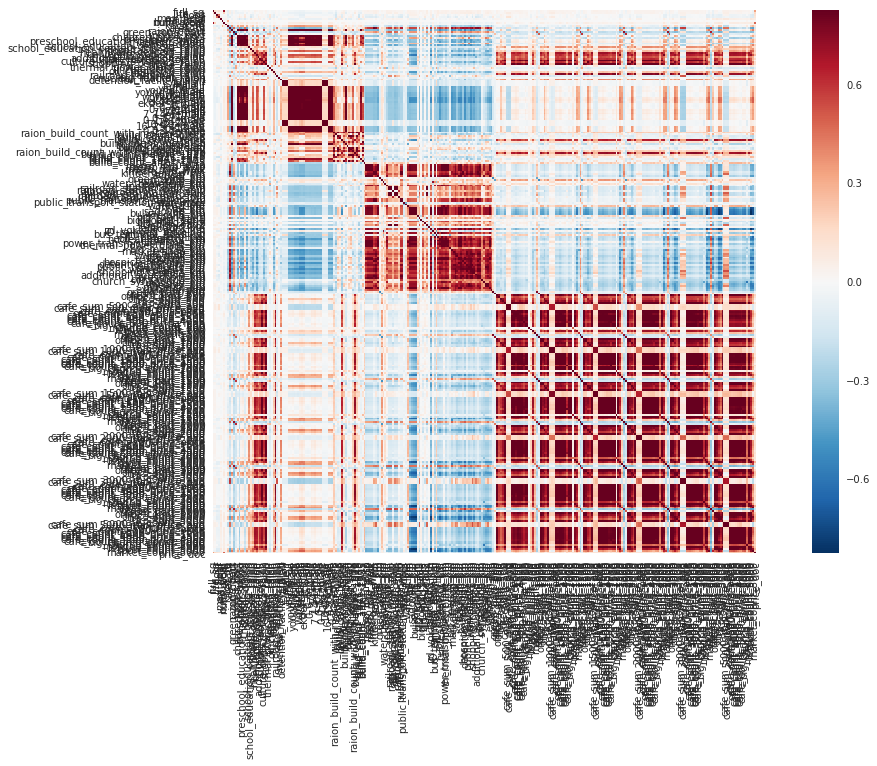

In [7]:
corrmax = train.corr()

f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corrmax, vmax=0.7, square=True)

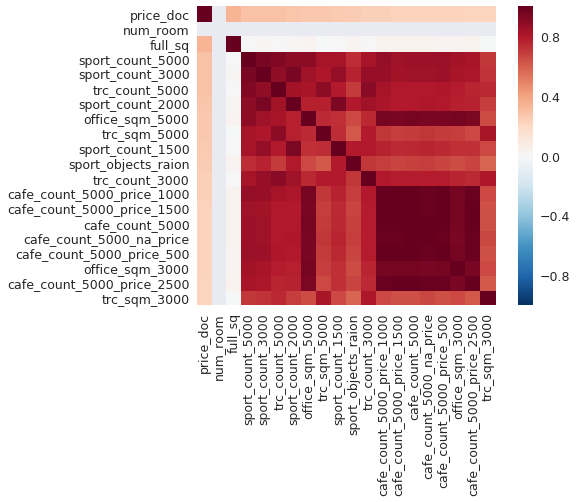

In [8]:
k = 20 #number of variables for heatmap
cols = corrmax.nlargest(k, 'price_doc')['price_doc'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=False, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Scatter plots between 'price_doc' and correlated variables (move like Jagger style)
Lets have a look at the scatter plot of correlated variables.

The good thing about this scatter plot is that we can spot outliers. Example of outliers can be seen at 

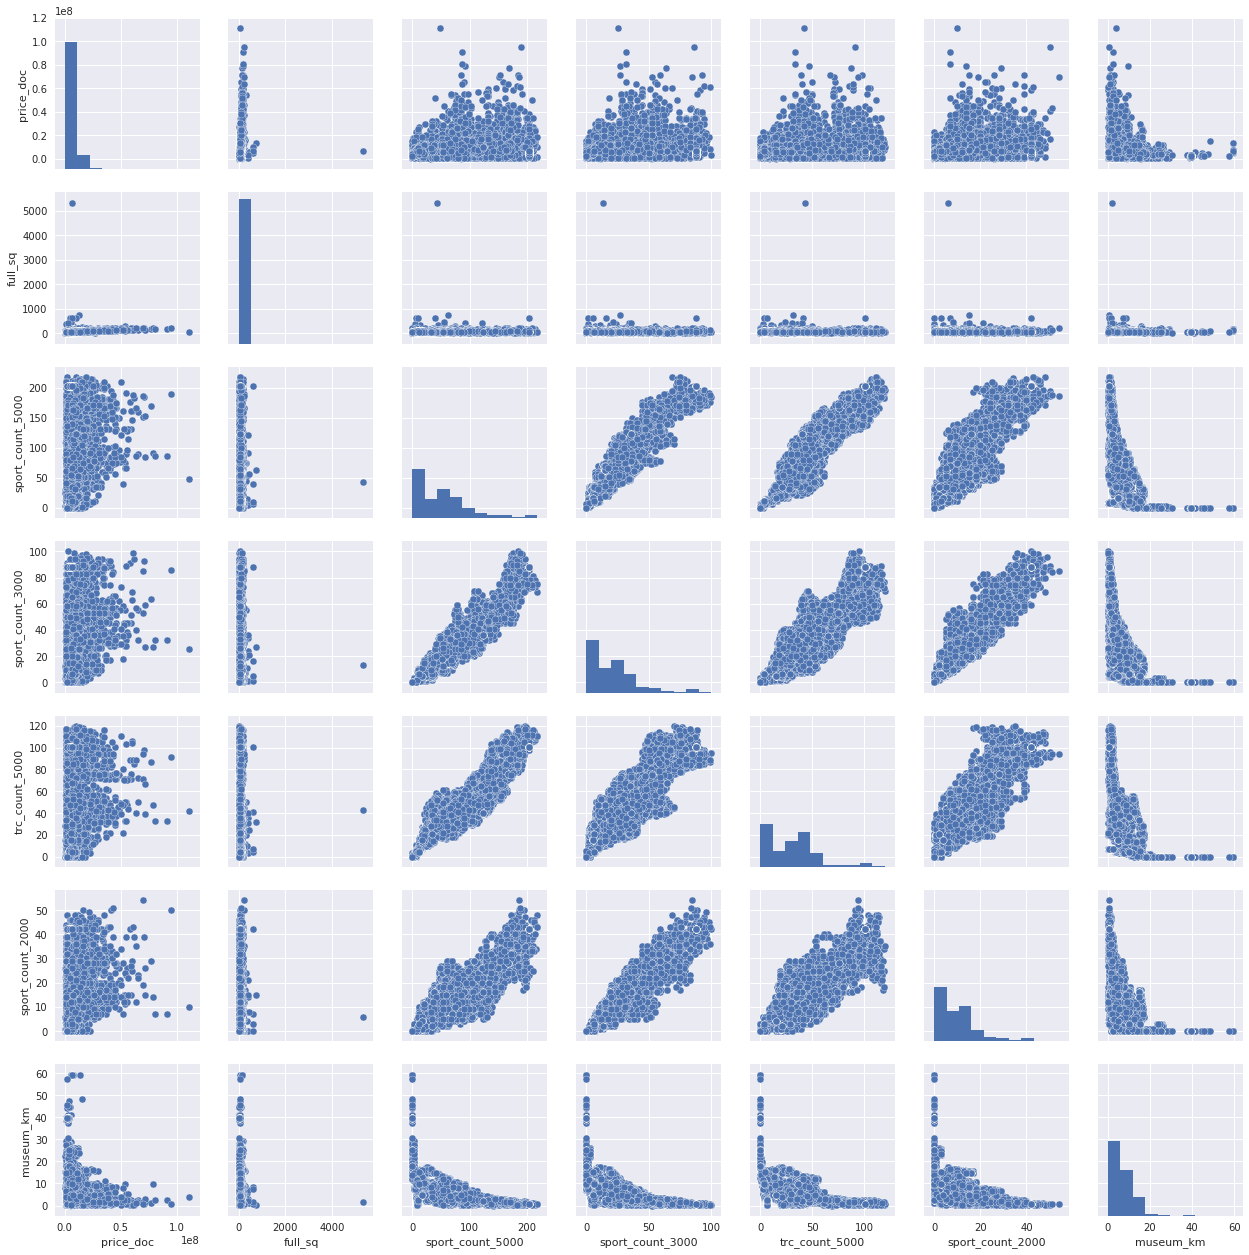

In [9]:
#scatterplot
sns.set()
cols = ['price_doc', 'full_sq', 'sport_count_5000', 'sport_count_3000', 'trc_count_5000', 'sport_count_2000','museum_km']
sns.pairplot(train[cols], size = 2.5)
plt.show();

The above shows that most of the highly correlated features do npt exhibit gausssian distribution. 
So those features need to be transformed

#### Missing values


In [10]:
#Borrowed from : https://www.kaggle.com/reshsekar15/notebook4c67feda25
def feature_summary(data):
    n_row=data.shape[0]
    features=pd.DataFrame()
    features_names=[]
    features_type = []
    features_counts=[]
    features_missing=[]
    names=data.columns.values
    for i in names:
        features_names.append(i)
        features_type.append(type(data.ix[1,i]))
        features_counts.append(data[i].value_counts().count())
        features_missing.append(data[data[i].isnull()].shape[0])
    features['name']=features_names
    features['type'] = features_type
    features['value counts']=features_counts
    features['missing']=features_missing
    features['percentage_missing']=features['missing']/n_row
    return (features)

In [11]:
print ("How training data from missing values perspective looks like:")
feature_summary(train)

How training data from missing values perspective looks like:


,name,type,value counts,missing,percentage_missing
0,timestamp,<class 'pandas.tslib.Timestamp'>,1161,0,0.000000
1,full_sq,<type 'numpy.int64'>,211,0,0.000000
2,life_sq,<type 'numpy.float64'>,175,6383,0.209478
3,floor,<type 'numpy.float64'>,41,167,0.005481
4,max_floor,<type 'numpy.float64'>,49,9572,0.314135
5,material,<type 'numpy.float64'>,6,9572,0.314135
6,build_year,<type 'numpy.float64'>,119,13605,0.446490
7,num_room,<type 'numpy.float64'>,13,9572,0.314135
8,kitch_sq,<type 'numpy.float64'>,74,9572,0.314135
9,state,<type 'numpy.float64'>,5,13559,0.444980


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30471 entries, 1 to 30473
Columns: 291 entries, timestamp to price_doc
dtypes: bool(12), datetime64[ns](1), float64(119), int64(156), object(3)
memory usage: 65.4+ MB


Accordingly, we have Boolean (12 features), numeric(119+156) features, objetc(3) and 1 datetime type.

This mkes our job difficult,
We need to tranform boolean ones into numerics,
extract year, month and day (day of week) from timestamp

### Combining train and test

In [13]:
df = train[train.columns.values[:-1]]

df = df.append(test, ignore_index= True)
print ("The train dataset size {} " , train.shape)
print ("The test dataset size {} " , test.shape)
print ("The combined dataset size {} " , df.shape)

('The train dataset size {} ', (30471, 291))
('The test dataset size {} ', (7662, 290))
('The combined dataset size {} ', (38133, 290))


In [14]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
hospital_beds_raion,17859,0.468335
cafe_sum_500_min_price_avg,16440,0.431123
cafe_sum_500_max_price_avg,16440,0.431123
cafe_avg_price_500,16440,0.431123
build_year,14654,0.384287
state,14253,0.373771
max_floor,9572,0.251016
material,9572,0.251016
num_room,9572,0.251016
kitch_sq,9572,0.251016


The above shows that roghly for around 38 features , the percentage of missing data is more than 5% , 
which usually such features are removed.

For the rest of the fetaures, the missing data is imputed by median (numeical) or the most frequent feature.


### Dividing data into categorical and numerical subsets

In [15]:
numerical_df = df.select_dtypes(include=[np.int64, np.float64])
categorical_df = df.select_dtypes(include=[np.object])
print ("Size of numerical subset {}", numerical_df.shape)
print ("Size of categorical subset {}", categorical_df.shape)

('Size of numerical subset {}', (38133, 274))
('Size of categorical subset {}', (38133, 3))


### Define Median Absolute Deviation Function
Function found in this link: http://stackoverflow.com/a/22357811/5082694

In [16]:

def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

### Remove Skew from Numerical data,  fixing missing values

In [17]:
for col in numerical_df.columns.values: 
    #exclude those columns having more than 0.05 missing data
    if percent[col] > 0.05:
        print (col, " Dropping column ", percent[col] )
        numerical_df = numerical_df.drop(col, axis=1)
    elif percent[col] > 0:
        median = numerical_df[col].median()
        idx = np.where(numerical_df[col].isnull())[0]
        numerical_df[col].iloc[idx] = median
        
        #Replace outliers with median
        outliers = np.where(is_outlier(numerical_df[col]))
        numerical_df[col].iloc[outliers] = median
        
        #transform skewed columns into log-log bases
        if skew(numerical_df[col]) > 0.75:
            numerical_df[col] = np.log(numerical_df[col])
            numerical_df[col] = numerical_df[col].apply(lambda x : 0 if x == - np.inf else x)
        
        #Finally  transform data into standard Z nomral distribution (i.e. mean= 0, sd=[-1,1])
        numerical_df[col] = Normalizer().fit_transform(numerical_df[col].reshape(1,-1))[0]

('life_sq', ' Dropping column ', 0.19822725723126949)


/opt/conda/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:21: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


('max_floor', ' Dropping column ', 0.25101618021136546)
('material', ' Dropping column ', 0.25101618021136546)
('build_year', ' Dropping column ', 0.38428657593160781)
('num_room', ' Dropping column ', 0.25101618021136546)
('kitch_sq', ' Dropping column ', 0.25101618021136546)
('state', ' Dropping column ', 0.37377074974431596)
('preschool_quota', ' Dropping column ', 0.21723966118584953)
('school_quota', ' Dropping column ', 0.21713476516403116)
('hospital_beds_raion', ' Dropping column ', 0.46833451341357879)
('raion_build_count_with_material_info', ' Dropping column ', 0.16282484986756876)
('build_count_block', ' Dropping column ', 0.16282484986756876)
('build_count_wood', ' Dropping column ', 0.16282484986756876)
('build_count_frame', ' Dropping column ', 0.16282484986756876)
('build_count_brick', ' Dropping column ', 0.16282484986756876)
('build_count_monolith', ' Dropping column ', 0.16282484986756876)
('build_count_panel', ' Dropping column ', 0.16282484986756876)
('build_count_

### Remove Skew from Categorical data,  fixing missing values

In [18]:
for col in categorical_df.columns.values:
    if percent[col] > 0.05:
        print ("Column {} will be dropped as it exceed threshold with {} ", col, percent[col])
        categorical_df = categorical_df.drop(col, axis = 1)
    elif percent[col] > 0:
        categorical_df[col] = categorical_df[col].fillna(categorical_df[col].value_counts().idxmax())  

#Converting categorical data into numeric ones using one hot encoding        
categorical_df = pd.get_dummies(categorical_df, columns=np.array(categorical_df.columns))        

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Converting Boolean into Numeric

In [19]:
boolean_df = df.select_dtypes([np.bool])
boolean_df.describe()

,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line
count,38133,38133,38133,38133,38133,38133,38133,38133,38133,38133,38133,38133
unique,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,False,False
freq,35514,36065,35551,37772,24464,36679,34779,37021,34303,35238,37029,37001


In [20]:
boolean_df.isnull().sum()

culture_objects_top_25       0
thermal_power_plant_raion    0
incineration_raion           0
oil_chemistry_raion          0
radiation_raion              0
railroad_terminal_raion      0
big_market_raion             0
nuclear_reactor_raion        0
detention_facility_raion     0
water_1line                  0
big_road1_1line              0
railroad_1line               0
dtype: int64

In [21]:
for col in boolean_df.columns.values:
    boolean_df[col] = boolean_df[col].apply (lambda x : 1 if x == False else 0)    

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [22]:
boolean_df.describe()

,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line
count,38133.000000,38133.000000,38133.000000,38133.000000,38133.000000,38133.000000,38133.000000,38133.000000,38133.000000,38133.000000,38133.000000,38133.000000
mean,0.931319,0.945769,0.932290,0.990533,0.641544,0.961870,0.912045,0.970839,0.899562,0.924082,0.971049,0.970314
std,0.252914,0.226476,0.251252,0.096837,0.479553,0.191512,0.283234,0.168260,0.300587,0.264871,0.167672,0.169721
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Extracting Year, Month and Day from timestamp

The timestamp data is decomposed into four new features:
1. Year 
2. Month (1-12)
3. Day of Week (1-7)
4. Ordinal

In [23]:
timestamp_df = df['timestamp']

In [24]:
year_df = timestamp_df.apply (lambda x : x.year)
month_df = timestamp_df.apply (lambda x : x.month)
day_df = timestamp_df.apply (lambda x : x.dayofweek)
ordinal_df = timestamp_df.apply (lambda x : x.toordinal())

In [25]:
timestamp_df = pd.concat([year_df, month_df, day_df, ordinal_df], axis=1, keys=['year','month','day','ts_ordinal'])

### Combining Categorical , Numerical , Boolean and Timestamps
After teh above cleaning, we combine both datasetsm

In [26]:
#we use join since two dataset have same onservations but different columns
df_all = pd. ([numerical_df, categorical_df, boolean_df, timestamp_df], axis=1)

train_new = df_all.iloc[: len(train)]
train_new = train_new.join(target_log, how='inner')

test_new = df_all.iloc[len(train):]

SyntaxError: invalid syntax (<ipython-input-26-726b664e6a6d>, line 2)

In [ ]:
np.sum(train_new.isnull().sum())

In [ ]:
print train_new.shape

In [ ]:
print test_new.shape

#### Divide data into  strictly training and validation subsets  Extract X and Y

In [ ]:
from sklearn.model_selection import train_test_split
train_data, validation_data = train_test_split(train_new, test_size = 0.3)

X_train = train_data[train_data.columns.values[:-1]]
y_train = train_data[train_data.columns.values[-1]]

X_validation = validation_data[validation_data.columns.values[:-1]]
y_validation = validation_data[validation_data.columns.values[-1]]


X_test = test_new



## Ensemble Learning model

### Linear Regression model

In [ ]:
def rmsle(y_true, y_pred):
    negative_entries = y_pred[np.argwhere(np.isnan(np.log(y_pred+1)))]
    if (negative_entries):
        print(negative_entries)
        y_pred[y_pred < 0] = 0
    return np.sqrt(mean_squared_error(np.log(y_true+1, dtype=np.float), np.log(y_pred+1, dtype=np.float)))

In [ ]:
def rmse(y_true, y_pred):
    negative_entries = y_pred[np.argwhere(np.isnan(np.log(y_pred+1)))]
    if (negative_entries):
        print(negative_entries)
        y_pred[y_pred < 0] = 0
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
#now we perfomr RidgeCV
estimator = RidgeCV(alphas=(0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 20.0, 100.0), 
                    fit_intercept=True, normalize=True, 
                    scoring='neg_mean_squared_error', cv=None, 
                    gcv_mode=None, store_cv_values=False)

estimator.fit(X=X_train, y= y_train)
est_validation = estimator.predict(X_validation)
est_validation = np.array(est_validation.flatten())
#y_validation = np.array(y_validation['SalePrice'], dtype=pd.Series).astype(np.float)
print("Root mean square logarithmic error:", rmsle(y_validation, est_validation))
print("Best alpha", estimator.alpha_)
print("Root mean square  error:", rmse(y_validation, est_validation))
print("Best alpha", estimator.alpha_)

In [ ]:
# The estimated coefficients will all be around 1:
# Those values, however, will show that the second parameter
# is more influential

coefs = np.std(X_train, 0)*estimator.coef_
coefs = coefs.sort_values(ascending=False)
coefs

The above shows that something is wrong badly. 
The coefficient difference between two the first three features and others is in order of magnitude. 


In [ ]:
#scatterplot
sns.set()
cols = ['price_doc', 'area_m', 'raion_popul', 'full_all', 'female_f', 'male_f','work_all','16_29_all']
sns.pairplot(train_new[cols], size = 2.5)
plt.show();

#### ElasticNet Regression

In [ ]:
#Borrowed from:https://www.kaggle.com/neviadomski/how-to-get-to-top-25-with-simple-model-sklearn
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [ ]:
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

In [ ]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001,0.0003, 0.0005, 0.0007, 0.001, 0.01,0.03, 0.1, 0.3, 1, 10], 
                                    l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(X_train, y_train)
train_test(ENSTest, X_train, X_validation, y_train, y_validation)

## Data cleaning
As a linear regression model cannot work with categorical variables I have to do some transformations. I will perform the following steps:

* Merge the test and training data. As I will fill out most of the NaNs with the median value I want to get medians that are representative of the entire data set.
* Create a numerical scale for **ecology**
* Create a boolean **is_investment** column based on **product_type**
* Create a boolean column for each **sub_area**
* Find NaN values and replace them, for the most part with the median value
* For **life_sq**, **num_room** and **kitch_sq** we can do better assumptions than the median
* **buildyear** contains some crazy outliers, clean those up

Note: I also tried the approach with creating a new column for columns where NaN values could be found, e.g. build_year_NaN set to True for a row where build_year was not available, but that did not yield any better result so I will skip this step here. Maybe it would work better for another type of model?

In [ ]:
test['price_doc'] = -1
data = pd.concat([train, test])

# Fix ecology column
ecology_map = {'poor': 1, 'satisfactory': 2, 'good': 3, 'excellent': 4, 'no data': np.NaN}
data['ecology'] = data['ecology'].apply(lambda x: ecology_map[x])

# There are 33 NaNs in the product_type column. 
# Set them to is_investment=True as that is the most common value.
data['is_investment'] = data['product_type'].apply(
    lambda x: False if x == 'OwnerOccupier' else True)
del data['product_type']

# Create a categorical value for each sub area
sub_areas = list(data['sub_area'].unique())
for area in sub_areas:
    data[area] = data['sub_area'].apply(lambda x: True if x == area else False)
del data['sub_area']

# Find columns with NaN values...
column_names = data.columns.values.tolist()
NaN_columns = []
for i, col_name in enumerate(column_names):
    s = sum(pd.isnull(data.iloc[:,i]))
    if s > 0:
        NaN_columns.append(i)
# ...and set most of these to the median value
for i in NaN_columns:
    if i in [2, 7, 8]: # life_sq, num_rooms, kitchen_sq
        continue
    else:
        data[column_names[i]]=data[column_names[i]].fillna(data[column_names[i]].median())

# Update NaN values for life_sq, num_room and kitch_sq
life_sq_to_full_sq = float(data['life_sq'].sum()) / \
    float(data.loc[data['life_sq'] > 0, 'full_sq'].sum())
average_room_size = float(data.loc[data['num_room'] > 0, 'full_sq'].sum()) / \
    float(data['num_room'].sum())
life_sq_to_kitch_sq = float(data['kitch_sq'].sum()) / \
    float(data.loc[data['kitch_sq'] > 0, 'full_sq'].sum())
data.loc[data['life_sq'].isnull(), 'life_sq'] = \
    data.loc[data['life_sq'].isnull(), 'full_sq'] * life_sq_to_full_sq
data.loc[data['num_room'].isnull(), 'num_room'] = \
    np.round(data.loc[data['num_room'].isnull(), 'full_sq'] / average_room_size)
data.loc[data['kitch_sq'].isnull(), 'kitch_sq'] = \
    data.loc[data['kitch_sq'].isnull(), 'full_sq'] * life_sq_to_kitch_sq

# Remove outliers from buildyear
median_build_year = data['build_year'].median()
data['build_year'] = data['build_year'].apply( \
    lambda x: median_build_year if x < 1800 else median_build_year if x > 2017 else x)

# Should output a 0 meaning that there are no NaNs left.
data.isnull().sum().sum()

There is a lot more that could be done with the data if you want to spend some time with it. I spent a few minutes looking at various outliers, e.g. the first and 99th quantile of the first columns. **max_floor** and **kitch_sq** certainly stands out but I will not spend time on analysing these values further.

In [ ]:
print("column name\tquantile 1\tquantile 99")
column_quantiles = {}
for c in data.columns.values[2:10]:
    column_quantiles[c] = (data[c].quantile(.0001), data[c].quantile(.9999))
    print(c, "\t", data[c].quantile(.0001), "\t", data[c].quantile(.9999))

## Brief data exploration
It's not my main mission to do an in-depth analysis of the various data points here but one big question is: how can we predict the price of an apartment when the data is collected over several years? Clearly time is a really important factor here - if there is a housing bubble in the middle of the period training a model on the years before the bubble will give poor predictions on what happens after.

What I (and probably Sberbank as well) am hoping for is that the macro file will contain data that, if fed to the model, will enable us to make predictions "independent" of time. Let's see if there is any ground for that assumption.

As we have no prices for the test set, July 2015 an onwards, we'll only look at the train set and hope the findings there can be extrapolated.

In [ ]:
time_group = data.set_index('timestamp').groupby(pd.TimeGrouper(freq='M'))
plt.figure(figsize=(15,8))
(time_group['price_doc'].sum() / time_group['full_sq'].sum()).plot()
plt.title('Price per square meter for Moscow apartements', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Price in RUB (starts at 60,000)')
plt.ylim([60000,180000])
plt.xlim(['2011-11-01', '2015-06-30'])
plt.grid()

Above is a plot of price per square meter for the apartments in the training set. We start the plot for November 2011 as the sample size before that is quite small (see below). Prices seem to peak in the late spring 2012 and are then followed by a dip to the lowest during autumn of 2012. From there they have kept rising. Let's see how the prices compare to inflation, CPI. To do that we need to import the macro data.

### Read the macro data
The macro data contains some missing fields. A simple approach seems to be to use the 'ffill' option, i.e. if a value is missing in a row, just copy the value from the row above. This will not work if the first row is missing a value so we will first front-fill and the back-fill to cater for that.

I will also do some reformatting of columns that contain a comma (,) as thousand separator.

In [ ]:
# Read macro data
# #! pattern found in some columns, treat as NaN
macro = pd.read_csv('macro.csv', na_values='#!', parse_dates=[0])

# Fill in NaN values
macro.fillna(method='ffill', inplace=True)
macro.fillna(method='bfill', inplace=True)

# Remove thousand separator and convert to double
macro_column_names = macro.columns.values.tolist()
for i, col_name in enumerate(macro_column_names):
    if macro.ix[:,i].dtype == object:
        macro.ix[:,i] = macro.ix[:,i].str.replace(',','')
        macro.ix[:,i] = pd.to_numeric(macro.ix[:,i])

### Consumer prices compared to CPI
After having loaded the macro data, let's do this comparison.

In [ ]:
square_meter_time_series = time_group['price_doc'].sum() / time_group['full_sq'].sum()

fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(square_meter_time_series, 'b-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price in RUB', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim([60000, 180000])
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(macro.timestamp, macro.cpi, '-', color='r')
ax2.set_ylabel('CPI', color='r')
ax2.tick_params('y', colors='r')
ax2.set_xlim([pd.to_datetime('2011-11-01'), pd.to_datetime('2015-06-30')])
# Set the scale to make the lines approximately match at the beginning of the period
ax2.set_ylim([110, 600])

fig.tight_layout()
plt.title('Price per square meter compared to Consumer Price Index (CPI)', fontsize=16)
plt.show()

We can see that the dip in late 2012 was really a dip in real prices but after that the prices seem to have more or less followed the inflation except for the final 4 months of the period where the flattening out actually means a price dip if we look at the inflation. There are a lot of other variables in the macro data. Plotting some of them against the mean square meter price would be interesting but I will leave that for a later endeavour.

What I would like to investigate next is if there is a difference in the price development for low, medium and high priced apartements. _Note that I will now look at the actual price, not price per square meter._

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(time_group['price_doc'].quantile(.9), color='b')
plt.plot(time_group['price_doc'].quantile(.5), color='r')
plt.plot(time_group['price_doc'].quantile(.1), color='g')
plt.xlim(['2011-11-01', '2015-06-30'])
plt.title('Price for the apartment at the 10, 50 and 90 percentile', fontsize=16)
plt.ylabel('Price in RUB')
plt.xlabel('Time')
plt.grid()

The price for the most expensive apartments seem to be a bit more volatile. It is interesting to see that during the dip in late 2012 the price for the cheapest apartements actually went up. Let's look at the sample sizes.

In [ ]:
plt.figure(figsize=(15,8))
time_group.size().plot(kind='bar')
plt.title('Number of apartements for each month in dataset', fontsize=16)
plt.ylabel('Number of apartements')
plt.xlabel('Time')
plt.grid()

The median price should be quite reliable but the 10- and 90th percentile respectively will be based on quite small samples for certain months; just above 20 apartements for the months where the total sample is about 200. Still, the price increase for the apartement on the 10th percentile (and drop for the 90th percentile) in the autumn 2012 is probably not just by chance. 

Not really sure what to make of it though. Did a downturn of the economy increase the demand for cheap apartements as people still needed to buy apartements but did not want to invest too much? You could probably draw a lot of conclusions for this by studying the data in more detail, e.g. "Were the largest apartements just not being sold those months?", "Did investement as opposed to owner-occupier purchase decrease?", et c., et c.

## Prediction model
So now over to the linear regression model.

The key challenge here will be to use the macro data together with the training data to create a good model. The price of an apartement is probably not only correlated to the macro data on the exact date of contract signing. Also, most of the columns in the macro data contain the same number for every day of each month. It makes sense to me to create one row of macro data per month and add that to the apartement data.

It could also be a good idea to try to assign different weights to the dates preceding the data of contract signing (and then get information from several preceding months into each apartement training example) but that's beyond what I want to try now.

In [ ]:
# Create one entry per each year and month, 
# fill with mean value of each column over month
macro['YearMonth'] = macro['timestamp'].map(lambda x: 100*x.year + x.month)
year_month_group = macro.groupby(by='YearMonth')
macro_year_month = year_month_group.mean()

# Create a YearMonth attribute for the apartments as well
data['YearMonth'] = data['timestamp'].map(lambda x: 100*x.year + x.month)

# Now merge the data..
full_data = pd.merge(data, macro_year_month, how='left', \
                     left_on='YearMonth', right_index=True)
del full_data['timestamp']

# ..and split back into train/test set
last_train_row = train.shape[0]-1
train_proc = full_data.iloc[:last_train_row]
test_proc = full_data.iloc[last_train_row:]

# Move target price data into separate array
train_target_prices = train_proc['price_doc']
del train_proc['price_doc']
del test_proc['price_doc']

I will now take 70% of the training set values to use for training the model and 30% for cross-validation to get a sense of how well the model performs.

In [ ]:
# Set a random state for repeatability
random_state = 11

# Create a train/test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split( \
    train_proc, train_target_prices, test_size=0.3, random_state=random_state)

# Create function for score metric, set any negatives to 0 to avoid math error
def rmsle(y_true, y_pred):
    negative_entries = y_pred[np.argwhere(np.isnan(np.log(y_pred+1)))]
    if (negative_entries):
        print(negative_entries)
        y_pred[y_pred < 0] = 0
    return np.sqrt(mean_squared_error(np.log(y_true+1), np.log(y_pred+1)))

I will use the above function to evaluate the root mean square logarithmic error of the estimator with my cross-validation set. I tried to feed it (with the make_scorer function) to the model to be used during training but for some reason it didn't work out. This is probably a main drawback as the model will minimize the wrong kind of error but I just don't have any good ideas on how to make it work.

As taking the logarithm of a negative value will yield a math error we will say that each negative prediction is 0. A good model would, of course, not predict a negative price of an apartement but as I stated already in the beginning, linear regression will not be the key to winning this competition..

In [ ]:
# RidgeCV
estimator = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 20.0, 100.0), 
                    fit_intercept=True, normalize=True, 
                    scoring='neg_mean_squared_error', cv=None, 
                    gcv_mode=None, store_cv_values=False)
estimator.fit(X_train, y_train)
print("Root mean square logarithmic error:", rmsle(y_test, estimator.predict(X_test)))
print("Best alpha", estimator.alpha_)

So what does a RMSLE of 0.55 mean? Let's compare the actual and predicted prices for a couple of apartements.

In [ ]:
print("\tActual price\t\tPredicted price")
for e in enumerate(zip(y_test[100:120], estimator.predict(X_test)[100:120])):
    print(e[0],"{:20,}".format(e[1][0]), "\t{:20,.0f}".format(e[1][1]))

It clearly does something and some of the values are sort of right but a few are way off. If I were to sell my apartement and the real estate agent gave me an estimate that turned out to be twice or half the final sale price based on the agency's advanced machine learning model I would be less than impressed..

The way RMSLE works, an error of 1 would mean that on average the model misclassifies the price with a factor of ~2.71 (e). An error of 0.55 means an average misclassification of about 70%.

Let's see what features had the highest weight.

In [ ]:
feature_weights = [x for x in zip(X_test.columns.values, estimator.coef_)]
feature_weights.sort(key=lambda x: x[1], reverse=True)
print("Strongest positive features")
for i in range(10):
    print(feature_weights[i])
print("\nStrongest negative features")
for i in range(10):
    print(feature_weights[-i-1])

I'm not 100% sure how to interpret the fact that 18 of the 20 most important features are areas. On the one hand this might indicate why linear regression won't really work for this type of problem/data. The price of an apartement is heavily influenced by its geographical location. On the other hand, the "area attributes" can only take the values 0 or 1 and (although I have normalized all input variables) it might take a pretty strong coefficient to bump up the importance of these values enough to get the correct effect on the target variable (sale price).

Maybe a linear regression model would work better if we had a "distance from city center" attribute that would take on linear and not binary values.

The way a human would estimate the price would certainly be to look at similar apartements in the area so any estimator that could simulate that would probably do better. Maybe that is what you could get a random forest regressor to do (i.e. split on the area attribute high up in the decision trees) but I'll leave that for a future experiment.

## Conclusion
I want to emphasize that I'm quite new at this and I probably made several mistakes along the way. I would be very happy if someone could point these out - that's the best way to learn. Further, I did not put too much rigour and thought into the different steps and perhaps there are ways to make this work better that I just did not see because I didn't spend enough time thinking about it but that's the benefit of not doing this professionally - I can just do enough to learn and then call it a day and move on once I think I have learned enough. To do a real analysis of all this data would for sure take months if not years.

### What to do next
I actually tried out a few other linear models (Lasso and ElasticNet) that do not penalize the square of errors but the absolute errors and they resulted in slightly, but not _that_ much, better results. It might also have been an idea to try out other things with the macro data, e.g. using a longer period of macro data instead of just the current month. However, I have a strong feeling that linear regression is not the way to approach this problem so if I continue working on it I will try out some other models.

Thank you, if you read all the way here and now at least you know what not to try out for the competition and hopefully you agree with my theory about why!